In [1]:
'''import os
from pathlib import Path
import touch
myfile = im
Path(myfile).touch() #creating a new empty file
print("Files in a directory -->",os.listdir())
print("We can see a file created succesfully")
print("-----------------------------------------------------")
# If file exists, delete it.
if os.path.isfile(myfile):
    os.remove(myfile)
    print("Favtutor file deleted using remove() function")
    print("Current files in directory -->",os.listdir())
    print("-----------------------------------------------------")
else:
    # If it fails, inform the user
    print("Error: %s file not found" % myfile)
'''

# Jika ada .DS_Store

'import os\nfrom pathlib import Path\nimport touch\nmyfile = im\nPath(myfile).touch() #creating a new empty file\nprint("Files in a directory -->",os.listdir())\nprint("We can see a file created succesfully")\nprint("-----------------------------------------------------")\n# If file exists, delete it.\nif os.path.isfile(myfile):\n    os.remove(myfile)\n    print("Favtutor file deleted using remove() function")\n    print("Current files in directory -->",os.listdir())\n    print("-----------------------------------------------------")\nelse:\n    # If it fails, inform the user\n    print("Error: %s file not found" % myfile)\n'

In [20]:
import prepare_data
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy
import rawpy
import pickle
from skimage.color import rgb2lab, lab2rgb

from utils.relight import relight_locally, apply_local_lights_rgb
from pipeline.pipeline import run_pipeline
from pipeline.pipeline_utils import normalize, denormalize, get_visible_raw_image, ratios2floats, white_balance, \
    get_metadata
from utils.gen_utils import check_dir
from noise_profiler.image_synthesizer import load_noise_model, synthesize_noisy_image_v2

In [21]:
# For dng format image Path

main = '/Users/m_feriansyahrt/Documents/S2/PCL/Proyek/day2night/dataset'
day = main + '/day/'
night = main + '/night_real/clean_raw/'

noise_model_path = 'noise_profiler/h-gauss-s20-v1'
noise_model, iso2b1_interp_splines, iso2b2_interp_splines = load_noise_model(path=noise_model_path)

sampel = 35
im = os.path.join(day,sorted(os.listdir(day))[sampel])
im

relight_local = True

In [22]:
im

'/Users/m_feriansyahrt/Documents/S2/PCL/Proyek/day2night/dataset/day/RAW_000_2021_08_26_03_51_41_105_000050_000001668607.dng'

In [23]:
'''# For jpg format image Path

main_jpg = '/Users/m_feriansyahrt/Documents/S2/PCL/bdd100k/images/10k/test'
jpg = sorted(os.listdir(main_jpg))[sampel]
img_jpg = os.path.join(main_jpg,jpg)

im = cv2.imread(img_jpg)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
plt.imshow(im)'''

"# For jpg format image Path\n\nmain_jpg = '/Users/m_feriansyahrt/Documents/S2/PCL/bdd100k/images/10k/test'\njpg = sorted(os.listdir(main_jpg))[sampel]\nimg_jpg = os.path.join(main_jpg,jpg)\n\nim = cv2.imread(img_jpg)\nim = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)\nplt.imshow(im)"

(3024, 4032, 3)


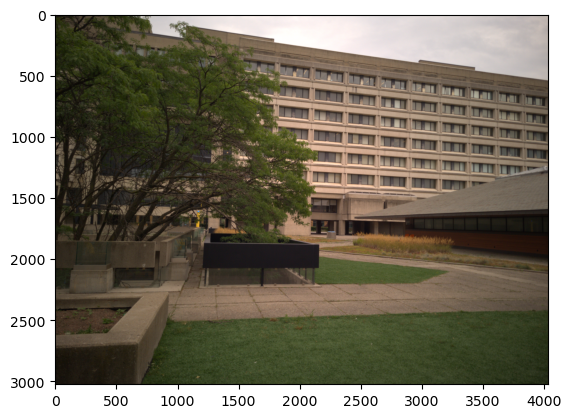

In [24]:
with rawpy.imread(im) as raw:
    rgb = raw.postprocess()
    
print(rgb.shape)
plt.imshow(rgb)

In [25]:
np.max(rgb)

255

In [26]:
def get_illum_normalized_by_g(illum_in_arr):
    return illum_in_arr[:, 0] / illum_in_arr[:, 1], illum_in_arr[:, 1] / illum_in_arr[:, 1], illum_in_arr[:, 2] / illum_in_arr[:, 1]

# load nighttime illuminants
gt_illum = scipy.io.loadmat('utils/gray_card_illum_dict.mat')
gt_illum = gt_illum['night_dict']

gt_illum[:, 0], gt_illum[:, 1], gt_illum[:, 2] = get_illum_normalized_by_g(gt_illum)

gt_illum_mean = np.mean(gt_illum, 0)
gt_illum_cov = np.cov(np.transpose(gt_illum))

In [27]:
if relight_local:
    light_mask_dirname = 'masks'
else:
    light_mask_dirname = None

In [28]:
# camera pipeline parameters
stages = ['raw', 'active_area_cropping', 'linearization', 'normal', 'white_balance',
          'demosaic', 'xyz', 'srgb', 'fix_orient', 'gamma', 'tone']

params = {
    'save_as': 'png',  # options: 'jpg', 'png', 'tif', etc.
    'white_balancer': 'default',  # options: default, or self-defined module
    'demosaicer': 'menon2007',  # options: '' for simple interpolation,
    #          'EA' for edge-aware,
    #          'VNG' for variable number of gradients,
    #          'menon2007' for Menon's algorithm
    'tone_curve': 'simple-s-curve',  # options: 'simple-s-curve', 'default', or self-defined module
}

In [29]:
img_bayer = get_visible_raw_image(im)
meta_data = get_metadata(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


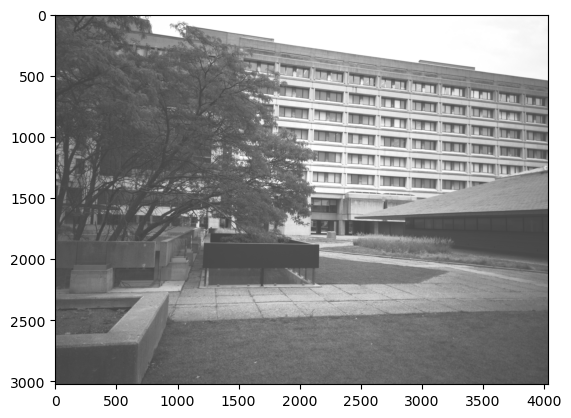

In [30]:
plt.imshow(cv2.cvtColor(img_bayer, cv2.COLOR_BGR2RGB))

In [31]:
iso_list = '50,1600,3200'.split(',')
for i in range(0, len(iso_list)):
    iso_list[i] = int(iso_list[i])
iso_list

[50, 1600, 3200]

In [32]:
'''Namespace(base_address='./dataset/day/', 
savefolderpath='synthetic_datasets', 
savefoldername='night', how_many_train=60, dim=True, 
relight=True, discard_black_level=False, clip=True, relight_local=True, 
min_num_lights=5, max_num_lights=5, min_light_size=0.5, 
max_light_size=1.0, save_light_masks=False, num_sat_lights=5, iso_list='1600,3200')'''

results_ = prepare_data.synth_night_imgs(img_bayer, meta_data, dim = True,
                                            relight = True, iso = iso_list[1],
                                            discard_black_level = False,
                                            _clip = True, relight_local = relight_local,
                                            min_num_lights = 2,
                                            max_num_lights = 3,
                                            min_light_size = 2,
                                            max_light_size = 3,
                                            num_sat_lights = 0,
                                            gt_illum_mean = gt_illum_mean, 
                                            gt_illum_cov = gt_illum_cov)

# num_sat_lights = berapa banyak "bola lampu dalam gambar"
# min_num_lights & max num_lights = seberapa terang
# min_light_size & max_light_size = seberapa terang

'''    
:param min_num_lights: Minimum number of local illuminants, in case of local relighting.
:param max_num_lights: Maximum number of local illuminants, in case of local relighting.
:param min_light_size: Minimum local light size as percent of image dimension, in case of local relighting.
:param max_light_size: Maximum local light size as percent of image dimension, in case of local relighting.
:param num_sat_lights: Number of small saturated local lights, in case of local relighting.'''

'    \n:param min_num_lights: Minimum number of local illuminants, in case of local relighting.\n:param max_num_lights: Maximum number of local illuminants, in case of local relighting.\n:param min_light_size: Minimum local light size as percent of image dimension, in case of local relighting.\n:param max_light_size: Maximum local light size as percent of image dimension, in case of local relighting.\n:param num_sat_lights: Number of small saturated local lights, in case of local relighting.'

In [33]:
if relight_local:
    example_night_synth, meta_data_night, local_lights = results_
else:
    example_night_synth, meta_data_night = results_
    local_lights = None
    
meta_data_night_raw = meta_data_night

In [34]:
#plt.imshow(cv2.cvtColor(example_night_synth,cv2.COLOR_BGR2RGB))

In [35]:
img_bayer,img_bayer.shape,example_night_synth, example_night_synth.shape

(array([[ 84,  73,  92, ..., 220, 419, 218],
        [ 72,  90,  78, ..., 404, 261, 414],
        [ 84,  73,  85, ..., 215, 413, 226],
        ..., 
        [ 71,  78,  71, ...,  95,  78,  91],
        [ 81,  71,  79, ...,  76,  92,  75],
        [ 70,  76,  69, ...,  94,  76,  95]], dtype=uint16),
 (3024, 4032),
 array([[65, 65, 66, ..., 70, 74, 70],
        [64, 66, 64, ..., 74, 67, 74],
        [65, 65, 65, ..., 70, 74, 70],
        ..., 
        [64, 67, 64, ..., 65, 64, 65],
        [68, 67, 68, ..., 64, 65, 64],
        [64, 67, 64, ..., 65, 64, 65]], dtype=uint16),
 (3024, 4032))

In [36]:
as_shot_neutral = meta_data_night['as_shot_neutral']  # keep as_shot_neutral
if relight_local:
    meta_data_night['as_shot_neutral'] = meta_data_night['avg_night_illuminant']  # modify as_shot_neutral
night_synth_srgb_avg = run_pipeline(example_night_synth, params=params, metadata=meta_data_night, stages=stages)
night_synth_srgb_avg = (night_synth_srgb_avg * 255).astype(np.uint8)
meta_data_night['as_shot_neutral'] = as_shot_neutral  # restore as_shot_neutral


(3024, 4032, 3)


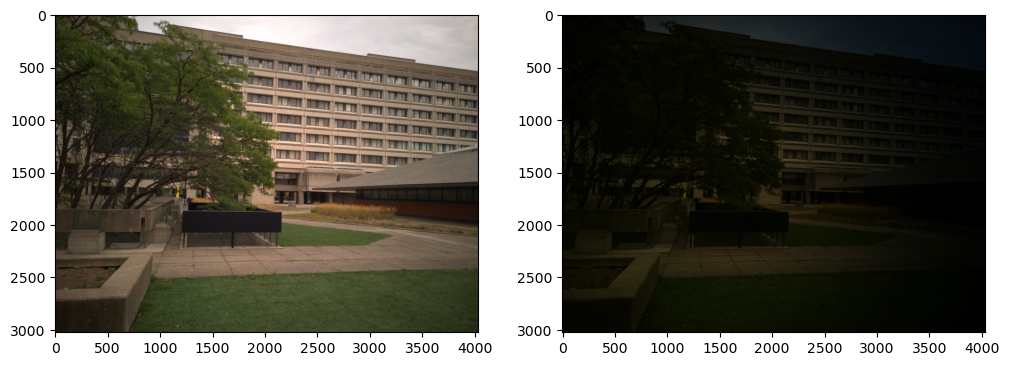

In [37]:
print(night_synth_srgb_avg.shape)

fig,ax = plt.subplots(1,2,figsize = [12,8])
ax[0].imshow(rgb)
ax[1].imshow(night_synth_srgb_avg)

n = 10
fig.savefig(f'ex{n}.jpg')

In [ ]:
noisy_night_image = synthesize_noisy_image_v2(example_night_synth, model=noise_model,
                                dst_iso=meta_data_night['iso'], min_val=0,
                                max_val=1023,
                                iso2b1_interp_splines=iso2b1_interp_splines,
                                iso2b2_interp_splines=iso2b2_interp_splines)

noisy_night_image = noisy_night_image.astype(np.uint16)

as_shot_neutral = meta_data_night['as_shot_neutral']  # keep as_shot_neutral
if relight_local:
    meta_data_night['as_shot_neutral'] = meta_data_night['avg_night_illuminant']  # modify as_shot_neutral
noisy_night_image_srgb = run_pipeline(noisy_night_image, params=params, metadata=meta_data_night, stages=stages)
noisy_night_image_srgb = (noisy_night_image_srgb * 255).astype(np.uint8)
meta_data_night['as_shot_neutral'] = as_shot_neutral  # restore as_shot_neutral

save_light_masks = True

if relight_local and save_light_masks and local_lights is not None:

    neutral_image = np.ones(night_synth_srgb_avg.shape, dtype=np.float32)

    # save individual local light masks
    for k, light in enumerate(local_lights[1:]):
        neutral_image_relight = apply_local_lights_rgb(neutral_image, [local_lights[0], light], clip=True,
                                                       invert_wb=True)
        # save combined light mask
        neutral_image_relight = apply_local_lights_rgb(neutral_image, local_lights, clip=True, invert_wb=True)


In [ ]:
fig,ax = plt.subplots(1,2,figsize = [12,8])
#ax[0].imshow(rgb)
ax[0].imshow(night_synth_srgb_avg)
ax[0].set_title('Clean Synthetic Image')
ax[1].imshow(noisy_night_image_srgb)
ax[1].set_title('Noisy Synthetic Image')

In [ ]:
plt.imshow(neutral_image_relight)

In [ ]:
# save image raw clean and raw noisy

path = '/Users/m_feriansyahrt/Documents/S2/PCL/Proyek/day2night/RAW_DATA/'
no = 1

# CLEAN
cv2.imwrite(path + f'clean_raw{no}' + '.png',
            example_night_synth.astype(np.uint16))
pickle.dump(meta_data_night_raw,
            open(path + f'metadata_raw{no}' + '.p', "wb"))

# NOISY
cv2.imwrite(path + f'noisy_raw{no}' + '.png',
            noisy_night_image)
#pickle.dump(meta_data_night_noisy,
#            open(path + f'noisy_raw{no}' + '.p', "wb"))


# SECOND PART Raw Processing

In [ ]:
from raw_prc_pipeline.pipeline_utils import get_visible_raw_image, get_metadata
from raw_prc_pipeline.pipeline import PipelineExecutor, RawProcessingPipelineDemo
from raw_prc_pipeline import expected_landscape_img_height, expected_landscape_img_width, expected_img_ext
from utilsbaseline import fraction_from_json, json_read
from pathlib import Path

In [ ]:
#Baseline

pipeline_params = {
    'tone_mapping': 'Flash', # options: Flash, Storm, Base, Linear, Drago, Mantiuk, Reinhard
    'illumination_estimation': 'gw', # ie algorithm, options: "gw", "wp", "sog", "iwp"
    'denoise_flg': True,
    'out_landscape_width': None,
    'out_landscape_height': None
}

pipeline_demo = RawProcessingPipelineDemo(**pipeline_params)

In [ ]:
# rubah format metadata pickle jd json
import json
# open pickle file
with open(path + f'metadata_raw{no}' + '.p', 'rb') as infile:
    obj = pickle.load(infile)

# convert pickle object to json object
json_obj = json.loads(json.dumps(obj, default=str))

# write the json file
with open(
        os.path.splitext(path + f'metadata_raw{no}' + '.p')[0] + '.json',
        'w',
        encoding='utf-8'
    ) as outfile:
    json.dump(json_obj, outfile, ensure_ascii=False, indent=4)

In [ ]:
#Load Raw Image

path = '/Users/m_feriansyahrt/Documents/S2/PCL/Proyek/day2night/RAW_DATA/'
name = 'RAW_000_2021_08_26_03_51_41_105_000050_000001668607'

png_path = Path(path + f'noisy_raw{no}' + '.png')
raw_image = cv2.imread(str(png_path), cv2.IMREAD_UNCHANGED)
meta_data = json_read(path + f'metadata_raw{no}' + '.json', object_hook=fraction_from_json)

In [ ]:
## linearize

linearized_image = pipeline_demo.linearize_raw(raw_image, meta_data)
plt.imshow(linearized_image, cmap='gray')

In [ ]:
## normalize

normalized_image = pipeline_demo.normalize(linearized_image, meta_data)
plt.imshow(normalized_image, cmap='gray')

In [ ]:
print(normalized_image.shape)

In [ ]:
def get_opencv_demsaic_flag(cfa_pattern, output_channel_order, alg_type='VNG'):
    # using opencv edge-aware demosaicing
    if alg_type != '':
        alg_type = '_' + alg_type
    if output_channel_order == 'BGR':
        if cfa_pattern == [0, 1, 1, 2]:  # RGGB
            opencv_demosaic_flag = eval('cv2.COLOR_BAYER_BG2BGR' + alg_type)
        elif cfa_pattern == [2, 1, 1, 0]:  # BGGR
            opencv_demosaic_flag = eval('cv2.COLOR_BAYER_RG2BGR' + alg_type)
        elif cfa_pattern == [1, 0, 2, 1]:  # GRBG
            opencv_demosaic_flag = eval('cv2.COLOR_BAYER_GB2BGR' + alg_type)
        elif cfa_pattern == [1, 2, 0, 1]:  # GBRG
            opencv_demosaic_flag = eval('cv2.COLOR_BAYER_GR2BGR' + alg_type)
        else:
            opencv_demosaic_flag = eval('cv2.COLOR_BAYER_BG2BGR' + alg_type)
            print("CFA pattern not identified.")
    else:  # RGB
        if cfa_pattern == [0, 1, 1, 2]:  # RGGB
            opencv_demosaic_flag = eval('cv2.COLOR_BAYER_BG2RGB' + alg_type)
        elif cfa_pattern == [2, 1, 1, 0]:  # BGGR
            opencv_demosaic_flag = eval('cv2.COLOR_BAYER_RG2RGB' + alg_type)
        elif cfa_pattern == [1, 0, 2, 1]:  # GRBG
            opencv_demosaic_flag = eval('cv2.COLOR_BAYER_GB2RGB' + alg_type)
        elif cfa_pattern == [1, 2, 0, 1]:  # GBRG
            opencv_demosaic_flag = eval('cv2.COLOR_BAYER_GR2RGB' + alg_type)
        else:
            opencv_demosaic_flag = eval('cv2.COLOR_BAYER_BG2RGB' + alg_type)
            print("CFA pattern not identified.")
    return opencv_demosaic_flag

def demosaic(bayer_image, cfa_pattern, output_channel_order='RGB', alg_type='VNG'):
    """
    Demosaic a Bayer image.
    :param bayer_image: Image in Bayer format, single channel.
    :param cfa_pattern: Bayer/CFA pattern.
    :param output_channel_order: Either RGB or BGR.
    :param alg_type: algorithm type. options: '', 'EA' for edge-aware, 'VNG' for variable number of gradients
    :return: Demosaiced image.
    """
    if alg_type == 'VNG':
        max_val = 255
        wb_image = (bayer_image * max_val).astype(dtype=np.uint8)
    else:
        max_val = 16383
        wb_image = (bayer_image * max_val).astype(dtype=np.uint16)

    if alg_type in ['', 'EA', 'VNG']:
        opencv_demosaic_flag = get_opencv_demsaic_flag(cfa_pattern, output_channel_order, alg_type=alg_type)
        demosaiced_image = cv2.cvtColor(wb_image, opencv_demosaic_flag)
    elif alg_type == 'menon2007':
        cfa_pattern_str = "".join(["RGB"[i] for i in cfa_pattern])
        demosaiced_image = demosaicing_CFA_Bayer_Menon2007(wb_image, pattern=cfa_pattern_str)
    else:
        raise ValueError('Unsupported demosaicing algorithm, alg_type = {}'.format(alg_type))

    demosaiced_image = demosaiced_image.astype(dtype=np.float32) / max_val

    return demosaiced_image

In [ ]:
## demosaic

demosaic_image = demosaic(normalized_image, meta_data_night['cfa_pattern'])
plt.imshow(np.clip(demosaic_image, 0, 1))

In [ ]:
print(demosaic_image.shape)

In [ ]:
# Gray World AWB

white_balanced_image = pipeline_demo.white_balance(demosaic_image, meta_data_night)
plt.imshow(white_balanced_image)

In [ ]:
#convert sRGB

xyz_image = pipeline_demo.xyz_transform(white_balanced_image, meta_data_night)
srgb_image = pipeline_demo.srgb_transform(xyz_image, meta_data_night)
plt.imshow(srgb_image)

# SECOND PART Image Processing

In [ ]:
# Denoising

# INPUT BERUPA CITRA NOISY
srgb_image_uint = (srgb_image * 255).round().astype(np.uint8)
im = cv2.fastNlMeansDenoisingColored(noisy_night_image_srgb, None, 10, 10, 7, 15) 

In [ ]:
fig,ax = plt.subplots(1,2,figsize = [12,8])
#ax[0].imshow(rgb)
ax[0].imshow(srgb_image_uint)
ax[0].set_title('Original')
ax[1].imshow(im)
ax[1].set_title('Denoised')


In [ ]:
## Contrast Enhancement

In [ ]:
# Local Contrast Enhancement

def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.float64(ycbcr)

def adjust_gamma(image, gamma):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype('float64')
    return cv2.LUT(image, table)

def gamma_filter(image, gamma):
    # Gamma correction 
    # Increase gamma for darkening, decrease for brightening
    filtr = np.power(image, gamma).clip(0, 255).astype(np.uint8) 
    return filtr

def luminance_corr(image,gamma):
    im_ycbcr = rgb2ycbcr(image)
    Y = im_ycbcr[:,:,0]
    M = gamma_filter(Y,gamma)
    eks = gamma ** ((0.5 - (1-M))/0.5)
    Y_ = []
    for i,j in zip(Y,eks):
        temp =[]
        for val,eksponen in zip(i,j):
            temp.append(val**eksponen.astype("float32"))
        Y_.append(temp)
    Y_ = np.array(Y_)
    return Y,Y_

def new_ycbcr(image,lum):
    origin = rgb2ycbcr(image)
    im_ycbcr = rgb2ycbcr(image)
    im_ycbcr[:,:,0] = lum
    return origin,im_ycbcr

In [ ]:
gamma = 1.8
Y,Y_ = luminance_corr(im,gamma)

In [ ]:
Y

In [ ]:
Y_

In [ ]:
fig,ax = plt.subplots(1,2,figsize = [12,8])
#ax[0].imshow(rgb)
ax[0].imshow(Y)
ax[0].set_title('Before Luminance Correction')
ax[1].imshow(Y_)
ax[1].set_title('After Luminance Correction')

fig.suptitle('Luminance Corr (Y Channel)')

In [ ]:
old_im_ycbcr, new_im_ycbcr = new_ycbcr(im,Y_)

fig,ax = plt.subplots(1,2,figsize = [12,8])
#ax[0].imshow(rgb)
ax[0].imshow(old_im_ycbcr.astype(np.uint8))
ax[0].set_title('Before LCC (YCbCr Color Space)')
ax[1].imshow(new_im_ycbcr.astype(np.uint8))
ax[1].set_title('After LCC (YCbCr Color Space)')


In [ ]:
def contrast_fixing(im_ycbcr,Y_stretched):
    # Extract the Y (luminance) channel from YCbCr
    Y = im_ycbcr[:, :, 0]

    # Compute the chroma radius (Cb and Cr channels) and chrominance
    Cb = im_ycbcr[:, :, 1]
    Cr = im_ycbcr[:, :, 2]
    chroma_radius = np.sqrt(Cb ** 2 + Cr ** 2)

    # Define thresholds for dark pixels
    luminance_threshold = 0.14
    chroma_threshold = 0.07

    # Find dark pixels
    dark_pixel_mask = (Y < luminance_threshold) & (chroma_radius < chroma_threshold)

    # Calculate cumulative histograms for Y
    hist_y = cv2.calcHist([Y], [0], None, [256], [0, 256])
    cumulative_hist_y = np.cumsum(hist_y)

    # Calculate cumulative histograms for Y hat -> After applying LCC
    hist_y_hat = cv2.calcHist([Y_stretched], [0], None, [256], [0, 256])
    cumulative_hist_y_hat = np.cumsum(hist_y_hat)

    # If there are dark pixels, calculate lower range
    if np.any(dark_pixel_mask):
        # Determine the threshold for the darkest 30% pixels
        total_pixels = Y.size
        percentile_threshold = 0.3
        threshold_value = int(total_pixels * percentile_threshold)

        # Find the bin value corresponding to the threshold in cumulative_hist_y_hat
        lower_range_y_hat = np.where(cumulative_hist_y_hat >= threshold_value)[0][0]

        # Find the bin value corresponding to the threshold in cumulative_hist_y
        lower_range_y = np.where(cumulative_hist_y >= threshold_value)[0][0]

        # Calculate lower range difference
        lower_range_difference = lower_range_y_hat - lower_range_y

        # Clip lower and upper ranges (maximum 50 bins)
        lower_range_difference = max(0, min(lower_range_difference, 50))

        # Apply histogram stretching to Y channel
        Y_stretched = cv2.normalize(Y, None, lower_range_difference, 255, cv2.NORM_MINMAX)
    else:
        # If no dark pixels, define lower range as the second percentile
        lower_range_y_hat = np.percentile(Y_stretched, 2)
        Y_stretched = Y

    # Calculate the upper range (always corresponds to the 98th percentile)
    upper_range_y_hat = np.percentile(Y_stretched, 98)

    # Stretch the image histogram using the determined ranges
    Y_stretched = cv2.normalize(Y_stretched, None, 0, 255, cv2.NORM_MINMAX)

    # Update the Y channel in the YCbCr image
    im_ycbcr[:, :, 0] = Y_stretched
    return im_ycbcr

def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float64)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

In [ ]:
newY_ = new_im_ycbcr[:,:,0] # after luminance correction
im_ycbcr = contrast_fixing(old_im_ycbcr.astype(np.uint8),newY_.astype(np.uint8))
im_rgb = ycbcr2rgb(im_ycbcr)

In [ ]:
fig,ax = plt.subplots(1,2,figsize = [12,8])
#ax[0].imshow(rgb)
ax[0].imshow(im_ycbcr)
ax[0].set_title('After LCC & Contrast Fixing (YCbCr)')
ax[1].imshow(im_rgb)
ax[1].set_title('After LCC & Contrast Fixing (RGB)')

In [ ]:
fig,ax = plt.subplots(1,2,figsize = [12,8])

ax[0].imshow(srgb_image_uint)
ax[0].set_title('Before LCC & Contrast Fixing (RGB)')
ax[1].imshow(im_rgb)
ax[1].set_title('After LCC & Contrast Fixing (RGB)')

In [ ]:
def saturation_fixing(rgb_after_lccC,ycbcr_before_lcc,ycbcr_after_lcc):
    Y = ycbcr_before_lcc[:,:,0]
    Y_ = ycbcr_after_lcc[:,:,0]
    
    R = rgb_after_lccC[:,:,0]
    G = rgb_after_lccC[:,:,1]
    B = rgb_after_lccC[:,:,2]
    
    init = np.zeros((im_rgb.shape[0],im_rgb.shape[1],im_rgb.shape[2]))
    init[:,:,0], init[:,:,1], init[:,:,2]  = R + Y, G + Y, B + Y    # C + Y
    
    init2 = np.zeros((im_rgb.shape[0],im_rgb.shape[1],im_rgb.shape[2]))
    init2[:,:,0], init2[:,:,1], init2[:,:,2]  = R - Y, G - Y, B - Y # C - Y
    
    idx_zero = np.where(Y == 0.0)
    for i,j in zip(idx_zero[0],idx_zero[1]):
        Y[i][j] = 10e-06
        
    div_factor = Y_/Y
    
    init[:,:,0], init[:,:,1], init[:,:,2] = 0.5 * div_factor * init[:,:,0], 0.5 * div_factor * init[:,:,1], 0.5 * div_factor * init[:,:,2]
    
    rgb_saturation_fixed = init + init2
    return rgb_saturation_fixed

In [ ]:
im_rgb_s = saturation_fixing(im_rgb,old_im_ycbcr,new_im_ycbcr)

In [ ]:
fig,ax = plt.subplots(1,3,figsize = [12,8])
#ax[0].imshow(rgb)
ax[0].imshow(srgb_image_uint)
ax[0].set_title('Noisy Original')
ax[1].imshow(im_rgb)
ax[1].set_title('LCC, ConFixing')
ax[2].imshow(im_rgb_s.astype(np.uint8))
ax[2].set_title('LCC, Con&SatFixing')

In [ ]:
# Global Mean Contrast

def glob_mean_contrast(im,beta):
    r,g,b = im[:,:,0],im[:,:,1],im[:,:,2]
    r_mean,g_mean,b_mean = np.mean(r),np.mean(g),np.mean(b)
    
    def calc(channel,mean):
        glob_mean = mean + beta * (channel-mean)
        return glob_mean
    
    r_glob,g_glob,b_glob = calc(r,r_mean),calc(g,g_mean),calc(b,b_mean)
    rgb_glob = np.dstack((r_glob,g_glob,b_glob))
    return rgb_glob

In [ ]:
im_glob = glob_mean_contrast(im_rgb,0.8) # Change beta value for tuning

fig,ax = plt.subplots(1,2,figsize = [12,8])
#ax[0].imshow(rgb)
ax[0].imshow(im_rgb)
ax[0].set_title('After LCC & Contrast Fixing')
ax[1].imshow(im_glob.astype(np.uint8))
ax[1].set_title('After Glob Contrast')

In [ ]:
# S-Curve Correction

def s_curve_corr1(image,alpha,lambda_val):
    im_zeros = np.zeros((image.shape[0],image.shape[1],image.shape[2]))
    for ch in range(image.shape[2]):
        c = image[:,:,ch]
        for idx_w,w in enumerate(c):
            for idx_h,h in enumerate(w):
                if h >= alpha:
                    pix = alpha + ((1 - alpha) * (((h - alpha)/(1 - alpha))**lambda_val))
                else:
                    pix = alpha - (alpha * ((1 - (h/alpha))**lambda_val))
                im_zeros[idx_w,idx_h,ch] = pix
    return im_zeros

def s_curve_corr2(image,alpha,lambda_value):
    im_zeros = np.zeros((image.shape[0],image.shape[1],image.shape[2]))
    for channel in range(3):  
        C = image[:, :, channel]
        S_CurveC = np.where(C >= alpha, alpha + (1 - alpha) * ((C - alpha) / (1 - alpha)) ** lambda_value, alpha - alpha * (1 - (C / alpha)) ** lambda_value)
        im_zeros[:, :, channel] = S_CurveC
    return im_zeros


In [ ]:
alpha = 0.5
lambda_value = 1.1

im_s_curve1 = s_curve_corr1(im_glob,alpha,lambda_value)
im_s_curve2 = s_curve_corr2(im_glob,alpha,lambda_value)

In [ ]:
fig,ax = plt.subplots(1,3,figsize = [12,8])
#ax[0].imshow(rgb)
ax[0].imshow(im_glob.astype(np.uint8))
ax[0].set_title('After Glob Contrast')
ax[1].imshow(im_s_curve1.astype(np.uint8))
ax[1].set_title('After S-Curve Correction 1')
ax[2].imshow(im_s_curve2.astype(np.uint8))
ax[2].set_title('After S-Curve Correction 2')

In [ ]:
# Histogram Stretching

def histogram_stretching(image):
    min_value = np.min(image)
    max_value = np.max(image)

    stretched_image = 255 * (image - min_value) / (max_value - min_value)
    return stretched_image

In [ ]:
im_histed = histogram_stretching(im_s_curve1)

fig,ax = plt.subplots(1,2,figsize = [12,8])
#ax[0].imshow(rgb)
ax[0].imshow(im_s_curve2.astype(np.uint8))
ax[0].set_title('After S-CurveCorr, Before Stretched')
ax[1].imshow(im_histed.astype(np.uint8))
ax[1].set_title('After Stretched')

In [ ]:
# Conditional Contrast Correction

def cond_contrast_corr(image,lower_t,upper_t,alpha,lambda_val,gamma):

    histed_ycbcr = rgb2ycbcr(image)
    luminance = histed_ycbcr[:,:,0]
    mean_luminance = np.mean(luminance)
    
    if mean_luminance <= lower_t:
        cond_im = s_curve_corr1(image,alpha,lambda_val)
        txt = 'S-Curve Correction Applied'
    
    elif mean_luminance >= upper_t:
        cond_im = gamma_filter(image,gamma) 
        txt = 'Gamma Filter Applied'
    
    else:
        cond_im = image
        txt = 'No Conditional Contrast Correction method Applied'
        
    return cond_im,mean_luminance,txt

In [ ]:
lower_t = 5
upper_t = 100
gamma = 1.15
alpha = 0.5
lambda_value = 1.1

im_cond_corr,mean_Y,txt = cond_contrast_corr(im_histed,lower_t,upper_t,alpha,lambda_value,gamma)
print('Mean of Luminance Channel from : ', mean_Y)
print('Adjust the threshold according to this value')

In [ ]:
im_histed = histogram_stretching(im_s_curve1)

fig,ax = plt.subplots(1,2,figsize = [12,8])
#ax[0].imshow(rgb)
ax[0].imshow(im_histed.astype(np.uint8))
ax[0].set_title('After Stretched') 
ax[1].imshow(im_cond_corr.astype(np.uint8))
ax[1].set_title(txt)

In [ ]:
## Sharpening

In [ ]:
# Unsharp Masking

def unsharp_masking(image,sigma): 
    im_zeros = np.zeros((image.shape[0],image.shape[1],image.shape[2]))
    
    for ch in range(image.shape[2]):    
        gaussian_filtered = cv2.GaussianBlur(image[:,:,ch], (0, 0), sigma)
        sharpened_image = image[:,:,ch] + (image[:,:,ch] - gaussian_filtered)
        sharpened_image = np.clip(sharpened_image, 0, 255)
        im_zeros[:,:,ch] = sharpened_image
        
    return im_zeros


In [ ]:
sigma = 1.5 
im_unsharped_masking = unsharp_masking(im_cond_corr,sigma)

fig,ax = plt.subplots(1,2,figsize = [12,8])
#ax[0].imshow(rgb)
ax[0].imshow(im_cond_corr.astype(np.uint8))
ax[0].set_title(txt)
ax[1].imshow(im_unsharped_masking.astype(np.uint8))
ax[1].set_title('After Unsharp Masking')

In [ ]:
## AWB

In [ ]:
# Grayness Index

def rgb2lab(rgb, gamma):
    # Ensure input is in the range [0, 255] and convert to float
    rgb = np.clip(rgb, 0, 255).astype(float)

    # Normalize RGB values to the range [0, 1]
    rgb /= 255.0

    # Apply gamma correction
    rgb = np.where(rgb <= 0.04045, rgb / (gamma * 12.92), ((rgb / gamma + 0.055) / (1.055)) ** (2.4 * gamma))

    # Linear transformation to XYZ color space
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    x = 0.4124564 * r + 0.3575761 * g + 0.1804375 * b
    y = 0.2126729 * r + 0.7151522 * g + 0.0721750 * b
    z = 0.0193339 * r + 0.1191920 * g + 0.9503041 * b

    # Normalize to D65 white point
    x /= 0.950456
    z /= 1.088754

    # Nonlinear transformation to LAB color space using vectorized operations
    epsilon = 6 / 29
    f = np.where(y > epsilon, y ** (1/3), (y / (3 * epsilon ** 2) + 4/29))
    l = 116 * f - 16
    a = (x - y) * 500
    b = (y - z) * 200

    return np.stack((l, a, b), axis=-1)

def lab2rgb(lab, gamma):
    # Nonlinear transformation from LAB to XYZ color space
    epsilon = 6 / 29
    f_inv = lambda t: np.where(t > epsilon, t ** (1/3), (t / (3 * epsilon ** 2) + 4/29))
    y = (lab[:, :, 0] + 16) / 116
    x = lab[:, :, 1] / 500 + y
    z = y - lab[:, :, 2] / 200

    x = f_inv(x)
    y = f_inv(y)
    z = f_inv(z)

    x *= 0.950456
    z *= 1.088754

    # Linear transformation from XYZ to RGB color space
    r = 3.2404542 * x - 1.5371385 * y - 0.4985314 * z
    g = -0.9692660 * x + 1.8760108 * y + 0.0415560 * z
    b = 0.0556434 * x - 0.2040259 * y + 1.0572252 * z

    # Apply gamma correction
    r = np.where(r <= 0.0031308, 12.92 * r, (1.055 * r) ** (1/gamma) - 0.055)
    g = np.where(g <= 0.0031308, 12.92 * g, (1.055 * g) ** (1/gamma) - 0.055)
    b = np.where(b <= 0.0031308, 12.92 * b, (1.055 * b) ** (1/gamma) - 0.055)

    # Scale RGB values to the range [0, 255]
    rgb = np.stack((r, g, b), axis=-1) * 255

    return np.clip(rgb, 0, 255).astype(np.uint8)

def grayness_index(image,threshold):
    
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    #lab_image = rgb2lab(image)
    #lab_image = rgb2lab(im_unsharped_masking,gamma)

    # Calculate the Grayness Index using the L channel
    l_channel = lab_image[:, :, 0]
    grayness_index = l_channel  
    achromatic_pixels = grayness_index <= threshold
    correction_factor = np.mean(l_channel[achromatic_pixels])
    balanced_l_channel = l_channel / correction_factor

    # Merge the LAB channels back
    balanced_lab_image = lab_image.copy()
    balanced_lab_image[:, :, 0] = balanced_l_channel

    # Convert the balanced LAB image back to BGR color space
    balanced_image = cv2.cvtColor(balanced_lab_image, cv2.COLOR_Lab2RGB)
    #balanced_image = lab2rgb(balanced_lab_image)
    #balanced_image = lab2rgb(balanced_lab_image,gamma)
    return balanced_image

In [ ]:
threshold = 6 # -> Tune the threshold value
im_awb = grayness_index(im_unsharped_masking.astype(np.uint8),threshold)

fig,ax = plt.subplots(1,2,figsize = [12,8])
#ax[0].imshow(rgb)
ax[0].imshow(im_unsharped_masking.astype(np.uint8))
ax[0].set_title('After Unsharp Masking')
ax[1].imshow(im_awb)
ax[1].set_title('After Grayness Index')

# FINAL COMPARATION

In [ ]:
fig,ax = plt.subplots(1,2,figsize = [12,8])
ax[0].imshow(rgb)
ax[0].set_title('Original Day Image')
ax[1].imshow(srgb_image_uint)
ax[1].set_title('Noisy Synthetic Night Image')

In [ ]:
fig,ax = plt.subplots(1,2,figsize = [12,8])
ax[0].imshow(rgb)
ax[0].set_title('Original Day Image')
ax[1].imshow(im_unsharped_masking.astype(np.uint8))
ax[1].set_title('Noisy Synthetic Night Image (After Unsharp Masking)')

In [ ]:
fig,ax = plt.subplots(1,2,figsize = [12,8])
ax[0].imshow(rgb)
ax[0].set_title('Original Day Image')
ax[1].imshow(im_awb)
ax[1].set_title('Noisy Synthetic Night Image (With Grayness Index)')